# Homework 3

In [1]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import pandas as pd
import numpy as np
import math

import wrds
import fredapi

from statsmodels.tsa.stattools import adfuller, kpss
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.stats.diagnostic import acorr_ljungbox as LjungBox
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

In [2]:
Fred_API_key_string = open('/home/william/Fred_API_key.txt').read().rstrip()

### The data you will use:

Total business inventories (seasonally adjusted numbers, monthly). 

This series is closely followed because it is a current indicator of consumer demand, and a leading indicator of businesses' forecasts of that demand.

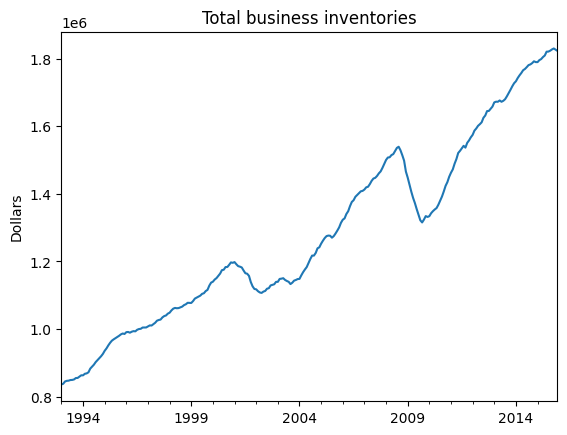

In [3]:
BUSINV = fredapi.Fred(api_key=Fred_API_key_string).get_series('BUSINV', observation_start = '1993-01-01', observation_end = '2015-12-31' )
BUSINV.index = pd.DatetimeIndex(BUSINV.index.values,freq='MS')
BUSINV.plot(title="Total business inventories",ylabel="Dollars");

We will model the growth rate of these inventories, calculated in the usual way:

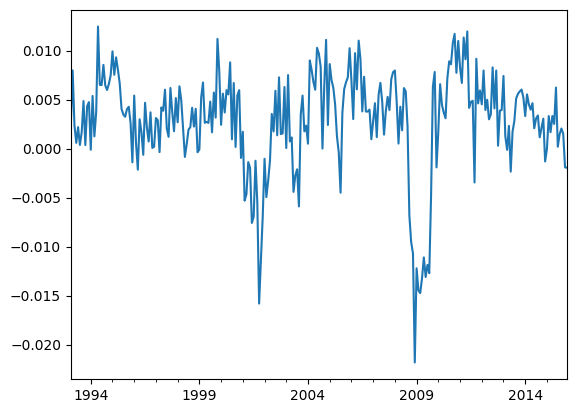

In [4]:
BUSINV_growth = np.log(BUSINV).diff().dropna()
BUSINV_growth.plot();

Save two datasets of this growth rate for use in our analysis: 
- A "training" dataset that ends in 2010. Use this to estimate and assess the models.
- A "test" dataset that runs from 2011-2015. Use this dataset to assess the out-of-sample forecasts that you make with the estimated models.

In [5]:
BUSINV_growth_training = BUSINV_growth[:'2010']

BUSINV_growth_test = BUSINV_growth['2011':'2015']

### Your task:

1. Check that the "training" data appear stationary using our usual tests.
2. Consider three models for the "training" data: AR(1), MA(1), and ARMA(1,1). Use the Box-Jenkins approach (as described in class) to select one of the three models as the best for this data.
3. For all three of the models mentioned above, plot forecasts through the end of 2015 (60 months beyond the end of the training data), along with prediction intervals at the usual 95% confidence level, and plot in the same figure the actual values in the "testing" data. 
4. What explains the different visual shapes of the forecasts? Which model seems most appropriate, just based on looking at the predictions visually? Which model performs the best in terms of RMSE during the testing period? 

### Analysis:

<b>1. Check that the training data appear stationary</b>: 

The ADF test clearly rejects, and the KPSS test fails to reject, so we conclude that the series is stationary.

In [6]:
print("ADF test results:")
display( adfuller(BUSINV_growth_training) )
print("KPSS test results:")
display( kpss(BUSINV_growth_training) )

ADF test results:


(-4.4935157916901725,
 0.0002020134469002403,
 9,
 205,
 {'1%': -3.4626576734812318,
  '5%': -2.8757444215841326,
  '10%': -2.5743412314098753},
 -1669.8573517238592)

KPSS test results:


/tmp/ipykernel_8920/3259388640.py:4: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  display( kpss(BUSINV_growth_training) )


(0.11531076528767578,
 0.1,
 9,
 {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739})

<b>2. Use the Box-Jenkins approach to select one of the three models as the best for this data.

First apply a Ljung-Box test to the raw data, and look at its ACF and PACF:

lb_stat     lb_pvalue
1  119.579606  7.819359e-28

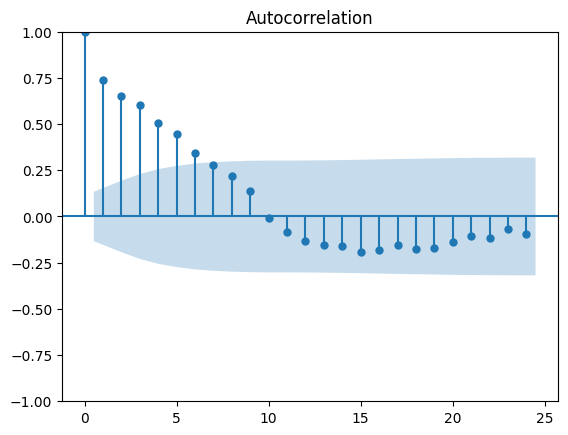

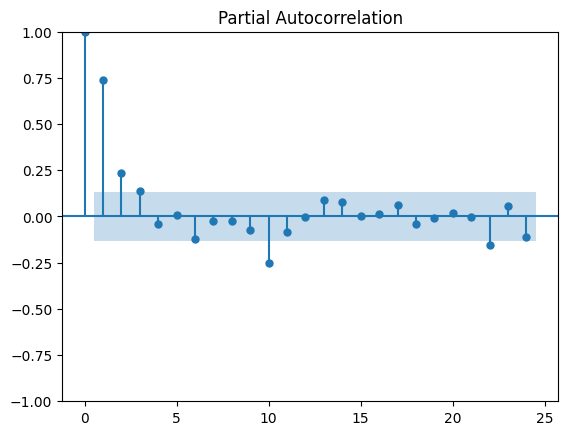

In [7]:
display(LjungBox(BUSINV_growth_training,lags=1))
plot_acf(BUSINV_growth_training);
plot_pacf(BUSINV_growth_training);

Fit the AR(1) model, and look its AIC, plus the same diagnostics as above.

AIC: -1785.0311
Ljung-Box test:


lb_stat  lb_pvalue
1  6.67591   0.009772

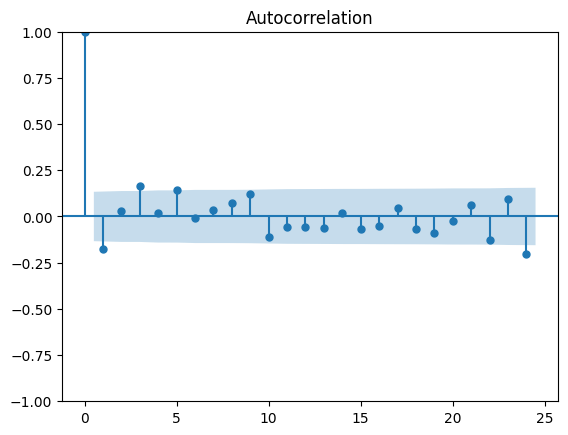

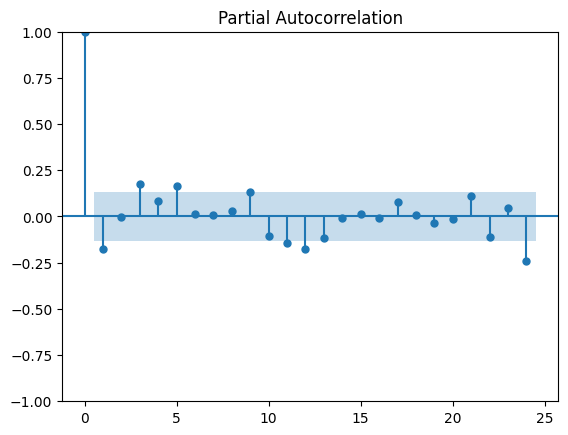

In [8]:
AR1 = ARIMA(BUSINV_growth_training,order=(1,0,0)).fit()
print("AIC: " + '%5.4f' % AR1.aic)
print("Ljung-Box test:")
display(LjungBox(AR1.resid,lags=1))
plot_acf( AR1.resid );
plot_pacf( AR1.resid );

Fit the MA(1) model, and look its AIC, plus the same diagnostics as above.

AIC: -1711.1956
Ljung-Box test:


lb_stat  lb_pvalue
1  16.857062    0.00004

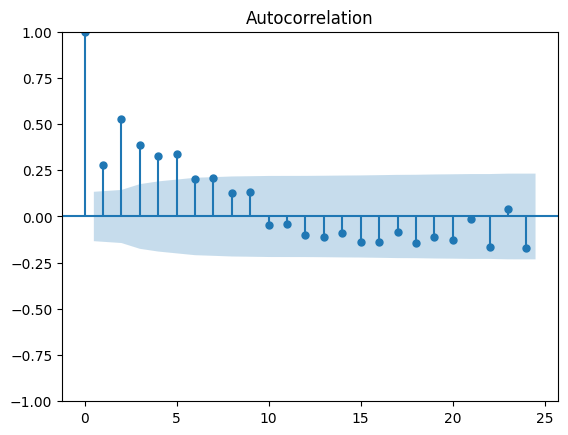

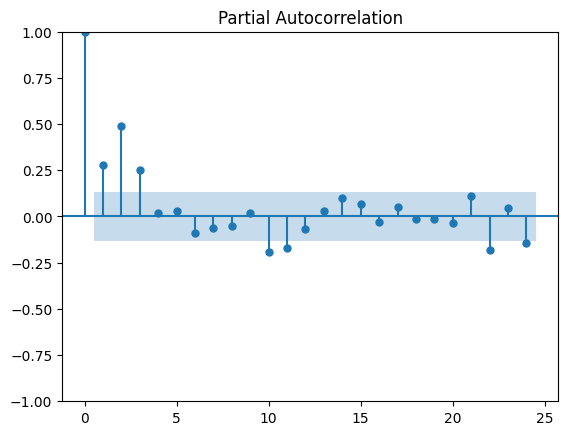

In [9]:
MA1 = ARIMA(BUSINV_growth_training,order=(0,0,1)).fit()
print("AIC: " + '%5.4f' % MA1.aic)
print("Ljung-Box test:")
display(LjungBox(MA1.resid,lags=1))
plot_acf(MA1.resid);
plot_pacf(MA1.resid);

Fit the ARMA(1,1) model, and look its AIC, plus the same diagnostics as above.

AIC: -1798.1493


lb_stat  lb_pvalue
1  0.003579   0.952294

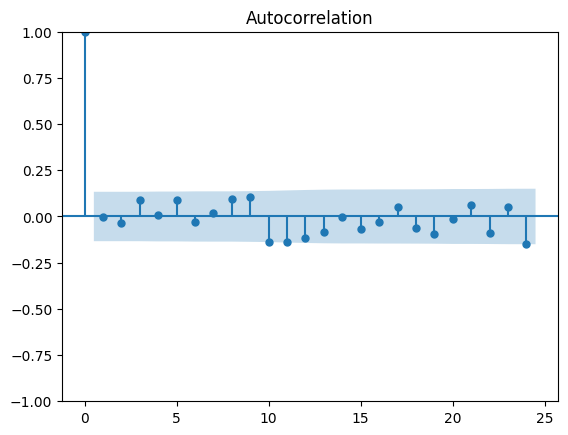

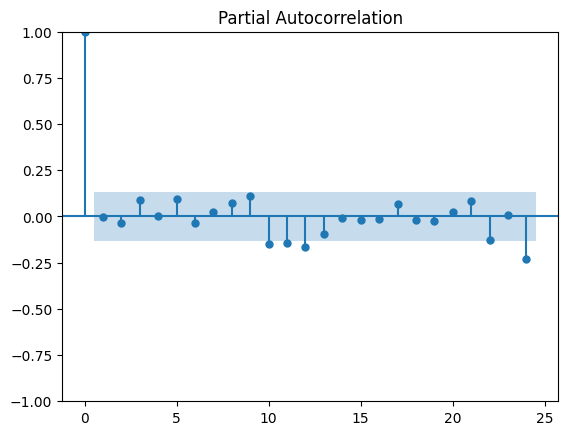

In [10]:
ARMA11 = ARIMA(BUSINV_growth_training,order=(1,0,1)).fit()
plot_acf( ARMA11.resid );
plot_pacf( ARMA11.resid );
print("AIC: " + '%5.4f' % ARMA11.aic)
LjungBox(ARMA11.resid,lags=1)

The ARMA(1,1) model achieves the lowest AIC, is the only one for which the Ljung-Box test on the residuals fails to reject, and, it is the only one that does not have strong ACF or PACF patterns in the residuals. 
<b>We conclude that the ARMA(1,1) model is the most appropriate for this series.</b>

<b>3. Plot forecasts, prediction intervals, and true data through the end of 2015.

AR(1)

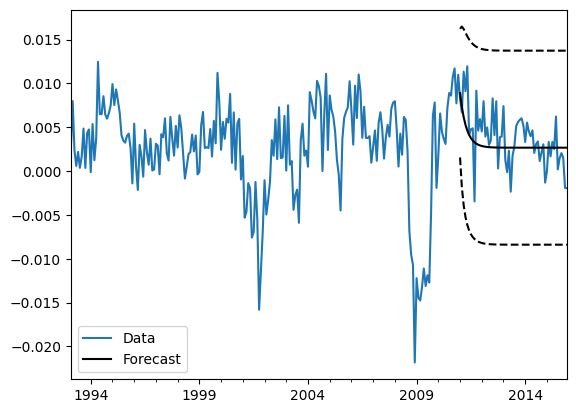

In [11]:
AR1_forecasts_frame = AR1.get_forecast(60).summary_frame()

BUSINV_growth.plot(legend=True,label="Data");
AR1_forecasts_frame['mean'].plot(legend=True,label="Forecast",color='black');
AR1_forecasts_frame['mean_ci_lower'].plot(legend=False,linestyle='--',color='black');
AR1_forecasts_frame['mean_ci_upper'].plot(legend=False,linestyle='--',color='black');

MA(1)

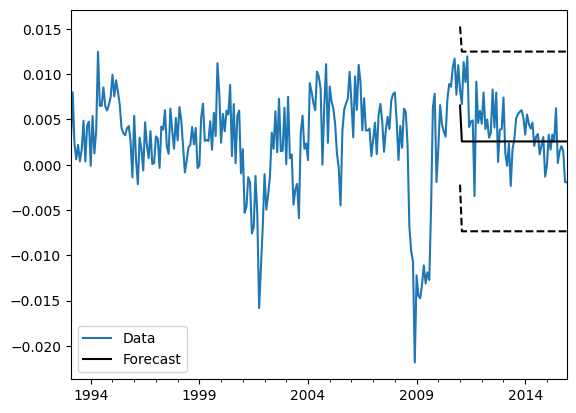

In [12]:
MA1_forecasts_frame = MA1.get_forecast(60).summary_frame()

BUSINV_growth.plot(legend=True,label="Data");
MA1_forecasts_frame['mean'].plot(legend=True,label="Forecast",color='black');
MA1_forecasts_frame['mean_ci_lower'].plot(legend=False,linestyle='--',color='black');
MA1_forecasts_frame['mean_ci_upper'].plot(legend=False,linestyle='--',color='black');

ARMA(1,1)

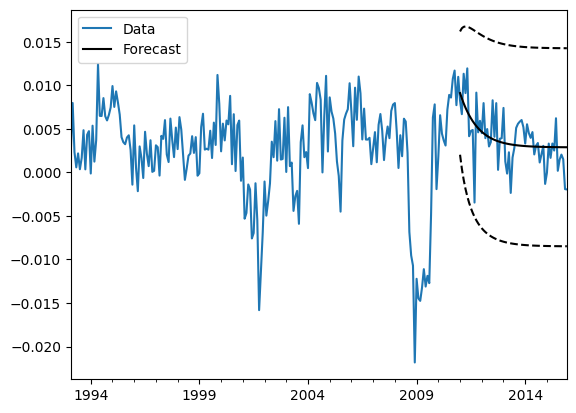

In [13]:
ARMA11_forecasts_frame = ARMA11.get_forecast(60).summary_frame()

BUSINV_growth.plot(legend=True,label="Data");
ARMA11_forecasts_frame['mean'].plot(legend=True,label="Forecast",color='black');
ARMA11_forecasts_frame['mean_ci_lower'].plot(legend=False,linestyle='--',color='black');
ARMA11_forecasts_frame['mean_ci_upper'].plot(legend=False,linestyle='--',color='black');

<b>4. What explains the different visual shapes of the forecasts? Which model seems most appropriate, just based on looking at the predictions visually? Which model performs the best in terms of RMSE during the testing period? </b>

First let's calculate and compare the RMSE values. 

(See the end of this notebook for an alternative calculation using a built-in function from the scikit-learn library.)

In [14]:
RMSE_AR1 = np.sqrt( ((AR1_forecasts_frame['mean'] - BUSINV_growth_test)**2).mean() )
RMSE_MA1 = np.sqrt( ((MA1_forecasts_frame['mean'] - BUSINV_growth_test)**2).mean() )
RMSE_ARMA11 = np.sqrt( ((ARMA11_forecasts_frame['mean'] - BUSINV_growth_test)**2).mean() )

print("AR(1) model RMSE: " + '%10.9f' % RMSE_AR1 )
print("MA(1) model RMSE: " + '%10.9f' % RMSE_MA1 )
print("ARMA(1,1) model RMSE: " + '%10.9f' % RMSE_ARMA11 )

AR(1) model RMSE: 0.002917226
MA(1) model RMSE: 0.003324488
ARMA(1,1) model RMSE: 0.002669768


The ARMA(1,1) model performs the best out-of-sample in terms of RMSE, as we would hope, since we also saw that it was the best-performing model in-sample based on information criteria and Ljung-Box test. 

Visually, this model's forecasts also has the most natural shape of all three: Each model's forecasts converge towards the same long-run mean, but the rate of that convergence appears most appropriate with the ARMA(1,1) model. The AR(1) and MA(1) both converge too quickly. 

For the MA(1) it is obvious why we get forecasts that converge too quickly. The very nature of this model is that any current fluctuations from trend are expected to die off almost immediately.

It may seem odd that the AR(1) model also converges too quickly to the mean. This is happening because there really is an MA feature to this model that is very short-lived, and in fact has a *negative* coefficient pushing the process very quickly back towards its average. This MA effect exists alongside an AR effect that looks more like a long-lived persistence.

The ARMA(1,1) is able to disentangle the AR and MA features of the data from each other. The model can therefore predict (correctly) that one part of the shock will die off very quickly (via the MA term), while the other part will last for a very long time (via the AR term). The result is that after an extreme value in the data, the model expects us to converge very rapidly at first, but then much more slowly in the long-run. This seems to be a correct description of the data and results in the better-behaving forecasts that we see above.

By contrast, the AR(1) model tries to capture both effects with just one term. It "averages" the AR and MA effects that are really there in the data, into one AR coefficient that is smaller than what the ARMA(1,1) model found, and thus leads to forecasts that die off more quickly.

MA effects are relatively unusual in economic data, but inventories are one example where they are actually common and you expect a negative coefficient, as we found in this example.

*Calculating RMSE using scikit-learn*: The scikit-learn library includes a function mean_squared_error that can be used instead of the manual calculation of RMSE above, if you prefer that. But be careful: RMSE is the *square root of* mean squared error, so you would need to take a square root of the number reported by this function in order to match the values we have listed above. Alternatively, there is an option squared=False that will do this for you.

In [15]:
from sklearn.metrics import mean_squared_error

print("AR(1) RMSE:")
print("our earlier calculation by hand: ")
print('%10.9f' % RMSE_AR1)
print("square root of the MSE reported by scikit-learn:")
MSE_AR1_skl = mean_squared_error( AR1.get_forecast(60).summary_frame()['mean'] , BUSINV_growth_test )
print( '%10.9f' % np.sqrt( MSE_AR1_skl ) )
print("using the squared=False option:")
RMSE_AR1_skl = mean_squared_error( AR1.get_forecast(60).summary_frame()['mean'] , BUSINV_growth_test, squared=False )
print( '%10.9f' % RMSE_AR1_skl )
print("\n")
 
print("MA(1) RMSE:")
print("our earlier calculation by hand: ")
print('%10.9f' % RMSE_MA1)
print("square root of the MSE reported by scikit-learn:")
MSE_MA1_skl = mean_squared_error( MA1.get_forecast(60).summary_frame()['mean'] , BUSINV_growth_test )
print( '%10.9f' % np.sqrt( MSE_MA1_skl ) )
print("using the squared=False option:")
RMSE_MA1_skl = mean_squared_error( MA1.get_forecast(60).summary_frame()['mean'] , BUSINV_growth_test, squared=False )
print( '%10.9f' % RMSE_MA1_skl )
print("\n")

print("ARMA(1,1) RMSE:")
print("our earlier calculation by hand: ")
print('%10.9f' % RMSE_ARMA11)
print("square root of the MSE reported by scikit-learn:")
MSE_ARMA11_skl = mean_squared_error( ARMA11.get_forecast(60).summary_frame()['mean'] , BUSINV_growth_test )
print( '%10.9f' % np.sqrt( MSE_ARMA11_skl ) )
print("using the squared=False option:")
RMSE_ARMA11_skl = mean_squared_error( ARMA11.get_forecast(60).summary_frame()['mean'] , BUSINV_growth_test, squared=False )
print( '%10.9f' % RMSE_ARMA11_skl )
print("\n")

AR(1) RMSE:
our earlier calculation by hand: 
0.002917226
square root of the MSE reported by scikit-learn:
0.002917226
using the squared=False option:
0.002917226


MA(1) RMSE:
our earlier calculation by hand: 
0.003324488
square root of the MSE reported by scikit-learn:
0.003324488
using the squared=False option:
0.003324488


ARMA(1,1) RMSE:
our earlier calculation by hand: 
0.002669768
square root of the MSE reported by scikit-learn:
0.002669768
using the squared=False option:
0.002669768


